## Датасет "Оставшееся количество циклов зарядки аккумулятора" 
Оригинальное название: *Battery Remaining Useful Life (RUL)*

Домашняя страница датасета:
https://github.com/ignavinuales/Battery_RUL_Prediction

На Каггле: https://www.kaggle.com/datasets/ignaciovinuales/battery-remaining-useful-life-rul

### Описание автора датасета

Гавайский Институт природной энергии протестировал 14 аккумуляторов типа NMC-LCO 18650 номинальной емкости 2.8 А·ч. Каждый аккумулятор был подвергнут более чем 1000 циклам разрядки/зарядки при температуре 25°C, включающим CC-CV зарядку в режиме C/2 и разрядку в режиме 1.5C.

На основе соответствующего датасета я создал новые признаки, описывающие динамику напряжения и силы тока для каждого цикла. Эти признаки можно использовать для предсказания оставшегося количества циклов аккумулятора. Датасет содержит сводную информацию о 14 аккумуляторах.

*The Hawaii Natural Energy Institute examined 14 NMC-LCO 18650 batteries with a nominal capacity of 2.8 Ah, which were cycled over 1000 times at 25°C with a CC-CV charge rate of C/2 rate and discharge rate of 1.5C.*

*From that source dataset, I created features that showcase the voltage and current behaviour over each cycle. Those features can be used to predict the remaining useful life (RUL) of the batteries. The dataset contains the summary of the 14 batteries.*

#### Признаки

- Индекс цикла
- F1: Полная продолжительность разрядки (с) 
- F2: Продолжительность разрядки с 3.6 В до 3.4 В (с)
- F3: Стартовое напряжение при разрядке (В)
- F4: Стартовое напряжение при зарядке (В)
- F5: Продолжительность зарядки до 4.15 В (с)
- F6: Продолжительность зарядки постоянным током (с)
- F7: Полная продолжительность зарядки (с)
- RUL: Целевая переменная (оставшееся количество циклов зарядки аккумулятора)

######
<div>
<img src="images/Voltage Discharging Cycle.png" width="550"/>
</div>

######
<div>
<img src="images/Voltage Charging Cycle.png" width="550"/>
</div>

######
<div>
<img src="images/Current Charging Cycle.png" width="550"/>
</div>



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline

In [12]:
df = pd.read_csv('data/Battery_RUL.csv')
df.drop(columns='Cycle_Index', inplace=True) # индекс не является свойством, и он может привести к data leak

In [13]:
df.head(10)

,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,2595.30,1151.488500,3.670,3.211,5460.001000,6755.01,10777.82,1112
1,7408.64,1172.512500,4.246,3.220,5508.992000,6762.02,10500.35,1111
2,7393.76,1112.992000,4.249,3.224,5508.993000,6762.02,10420.38,1110
3,7385.50,1080.320667,4.250,3.225,5502.016000,6762.02,10322.81,1109
4,65022.75,29813.487000,4.290,3.398,5480.992000,53213.54,56699.65,1107
5,3301.18,1194.235077,3.674,3.504,5023.633636,5977.38,5977.38,1106
6,5955.30,1220.135329,4.013,3.501,5017.495000,5967.55,5967.55,1105
7,5951.20,1220.135329,4.014,3.501,5017.496000,5962.21,5962.21,1104
8,5945.44,1216.920914,4.014,3.501,5009.993667,5954.91,5954.91,1103
9,435251.49,263086.078000,4.267,3.086,269.984000,443700.02,443700.02,1102


In [14]:
df.shape

(15064, 8)

In [15]:
# Для удобства переименуем столбцы согласно авторской нотации

new_col_labels = ['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7']

df_column_dict = dict(zip(df.columns, new_col_labels))
df_column_dict

{'Discharge Time (s)': 'F1',
 'Decrement 3.6-3.4V (s)': 'F2',
 'Max. Voltage Dischar. (V)': 'F3',
 'Min. Voltage Charg. (V)': 'F4',
 'Time at 4.15V (s)': 'F5',
 'Time constant current (s)': 'F6',
 'Charging time (s)': 'F7'}

In [16]:
df.rename(mapper=df_column_dict, axis=1, inplace=True)

### Разведочный анализ и предобработка

In [17]:
# Пропусков нет

df.isnull().sum()

F1     0
F2     0
F3     0
F4     0
F5     0
F6     0
F7     0
RUL    0
dtype: int64

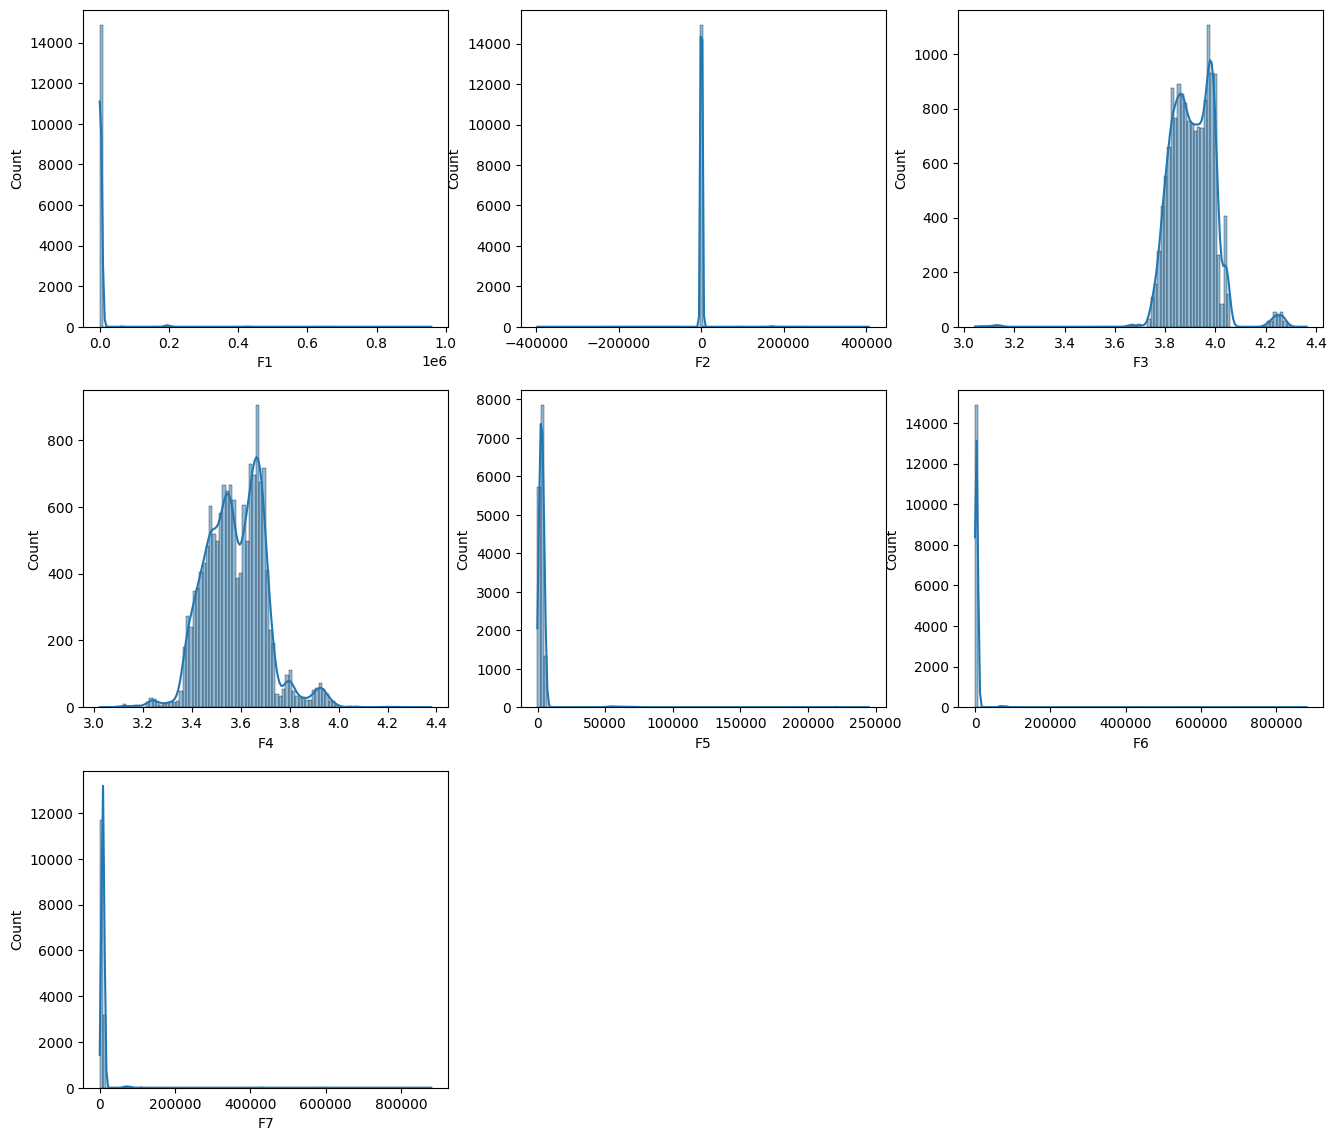

In [18]:
plt.figure(figsize=(16,14))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.histplot(x=col, data=df, bins=100, kde=True)

plt.show()

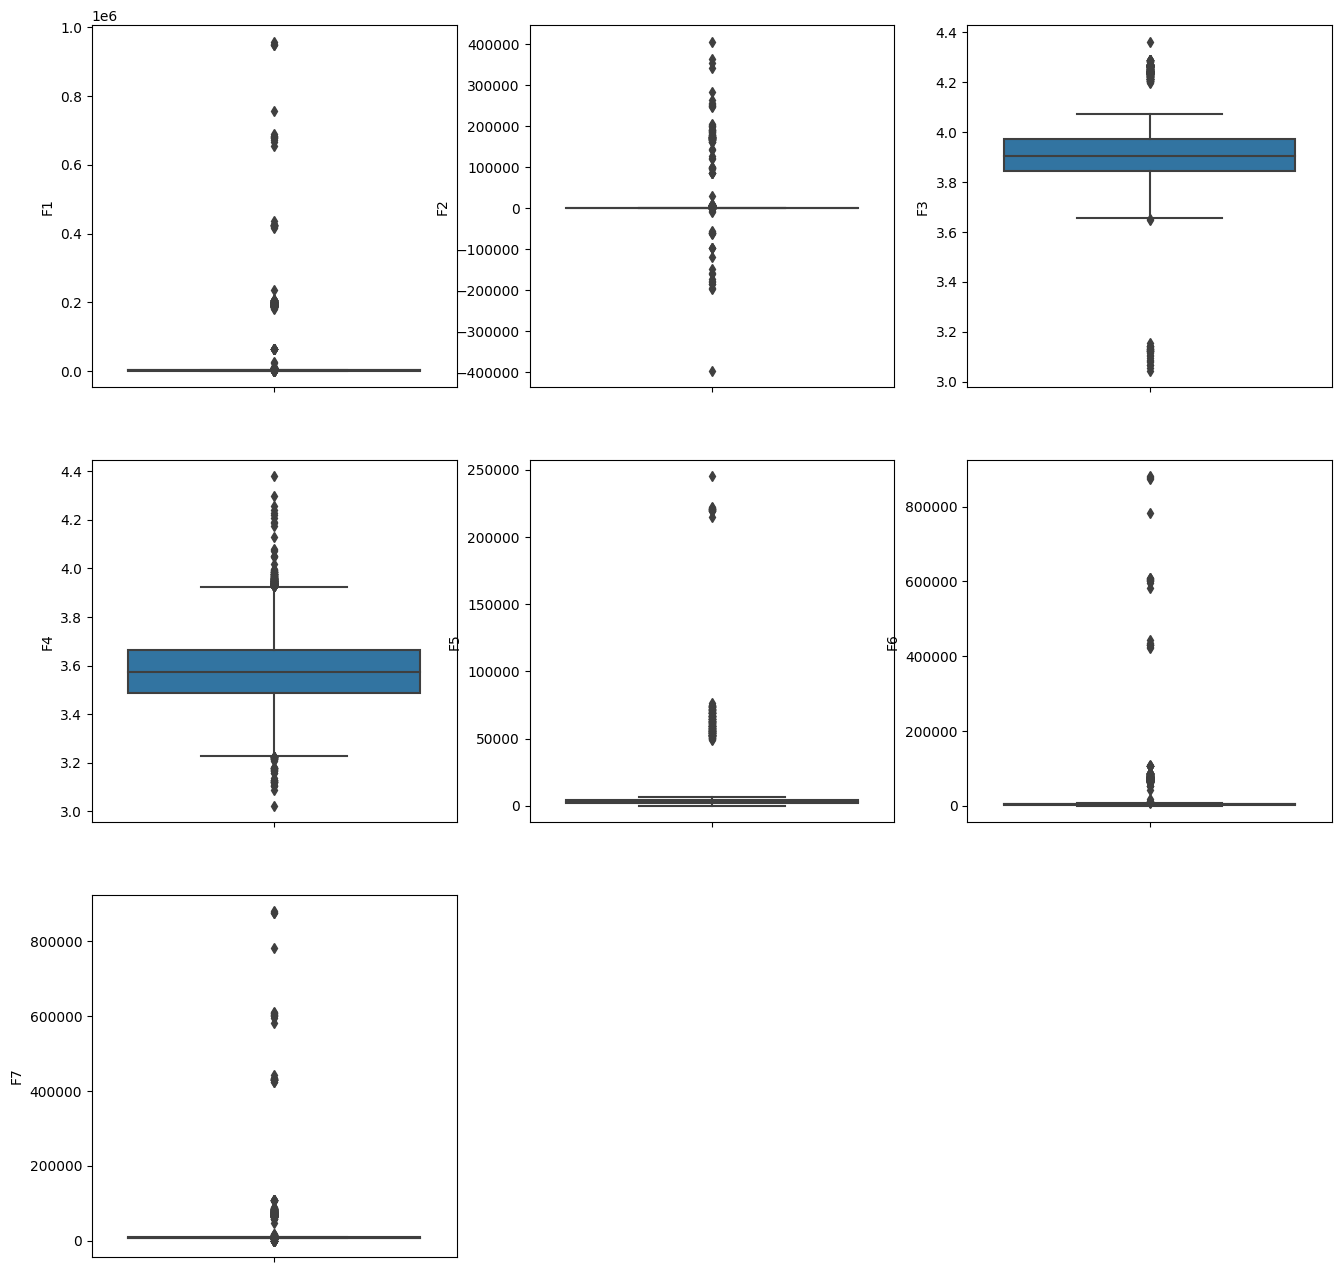

In [19]:
plt.figure(figsize=(16,16))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=col, data=df)

plt.show()

In [20]:
# У признаков F1, F2, F5, F6, F7 наблюдаются серьезные выбросы

In [21]:
df.iloc[10:19] # Пример выброса (строка 14) - значения у данных пяти признаков отличаются на 2 порядка от соседних

,F1,F2,F3,F4,F5,F6,F7,RUL
10,3228.58,1135.349333,3.689,3.485,5033.075692,5969.89,5969.89,1101
11,6019.90,1058.279724,4.045,3.475,5053.842846,5980.77,5980.77,1100
12,6026.59,1049.487845,4.047,3.477,5046.429500,5966.82,5966.82,1099
13,6008.07,1065.372059,4.045,3.480,5033.075769,5954.47,5954.47,1098
14,423271.35,168773.265000,4.270,3.108,219923.996000,430028.84,430028.84,1097
15,2261.34,883.200000,4.038,3.901,1949.664000,2922.69,6070.11,1096
16,2259.46,883.199000,4.042,3.373,5181.377000,6161.38,9310.98,1095
17,2256.61,878.400000,4.042,3.374,5181.375000,6154.37,9296.64,1094
18,2252.83,873.601000,4.043,3.374,5174.334000,6147.33,9243.58,1093


In [22]:
df.iloc[7603:7612] # Пример выброса (строка 7607) - отрицательное значение

,F1,F2,F3,F4,F5,F6,F7,RUL
7603,2188.81,818.375,4.044,3.384,5002.813,5965.38,9136.38,1049
7604,2186.38,818.438,4.044,3.385,4999.313,5958.31,9101.31,1048
7605,2186.38,818.375,4.045,3.385,4992.375,5958.38,9136.38,1047
7606,2184.00,806.375,4.026,3.705,4956.000,5922.00,9142.00,1046
7607,207013.99,-98271.841,4.272,3.159,73349.980,85080.00,85080.00,1045
7608,11755.36,807.000,4.005,3.380,5250.080,6200.48,9556.67,1044
7609,2184.00,814.400,4.008,3.389,5012.353,5948.35,9188.35,1043
7610,2183.74,816.000,4.009,3.388,5012.318,5948.32,9188.32,1042
7611,2172.00,816.000,4.009,3.389,5005.152,5948.35,9192.90,1041


In [23]:
df.iloc[11822:11831] # Пример выброса (строка 11826) - значения у данных пяти признаков отличаются на 1-3 порядка от соседних

,F1,F2,F3,F4,F5,F6,F7,RUL
11822,1017.06,273.371429,3.800,3.674,1457.375000,2096.38,7823.50,41
11823,1014.88,273.500000,3.800,3.673,1452.875000,2096.38,7793.94,40
11824,1008.00,272.457143,3.800,3.675,1448.375000,2060.38,7795.12,39
11825,1012.25,271.542857,3.799,3.676,1443.875000,2060.38,7792.44,38
11826,32.38,42.105263,3.114,3.674,114.250000,8.00,8.00,37
11827,1014.69,271.600000,3.799,3.671,1529.375000,2168.38,7963.75,36
11828,1014.62,271.657143,3.799,3.673,1448.375000,2060.38,7863.06,35
11829,1009.75,269.828571,3.799,3.673,1443.875000,2060.38,7856.69,34
11830,1007.00,268.914286,3.798,3.674,1432.884429,2060.31,7783.56,33


In [24]:
# Подобные выбросы невозможно интерпретировать как корректные результаты измерений, поэтому перед нами либо
# ошибки измерений, либо ошибки обработки. 
# Данные выбросы необходимо удалить.
# Для определения порога отсечения построим графики персентилей на концах интервалов.

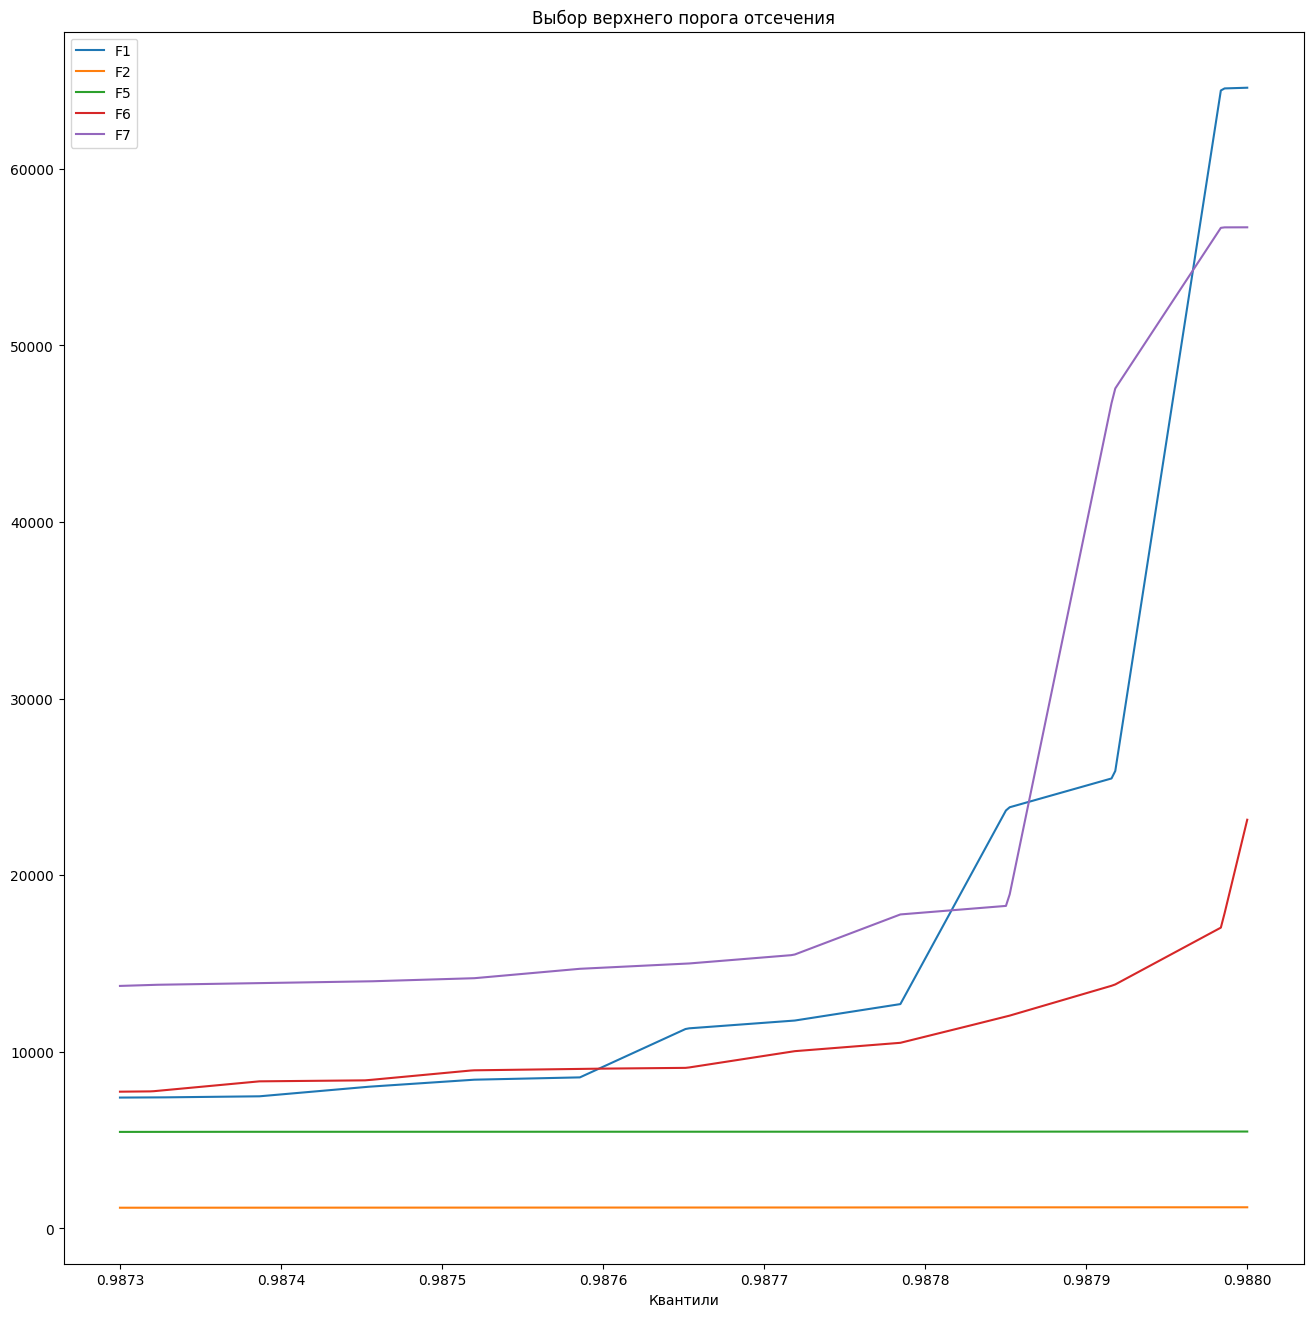

In [25]:
q0 = 0.9873
q1 = 0.9880
pts = 300

plt.figure(figsize=(16,16))
plt.plot(np.linspace(q0, q1, pts), [ df.F1.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F1')
plt.plot(np.linspace(q0, q1, pts), [ df.F2.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F2')
plt.plot(np.linspace(q0, q1, pts), [ df.F5.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F5')
plt.plot(np.linspace(q0, q1, pts), [ df.F6.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F6')
plt.plot(np.linspace(q0, q1, pts), [ df.F7.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F7')
plt.title(label='Выбор верхнего порога отсечения')
plt.xlabel('Квантили')
plt.legend()
plt.show()

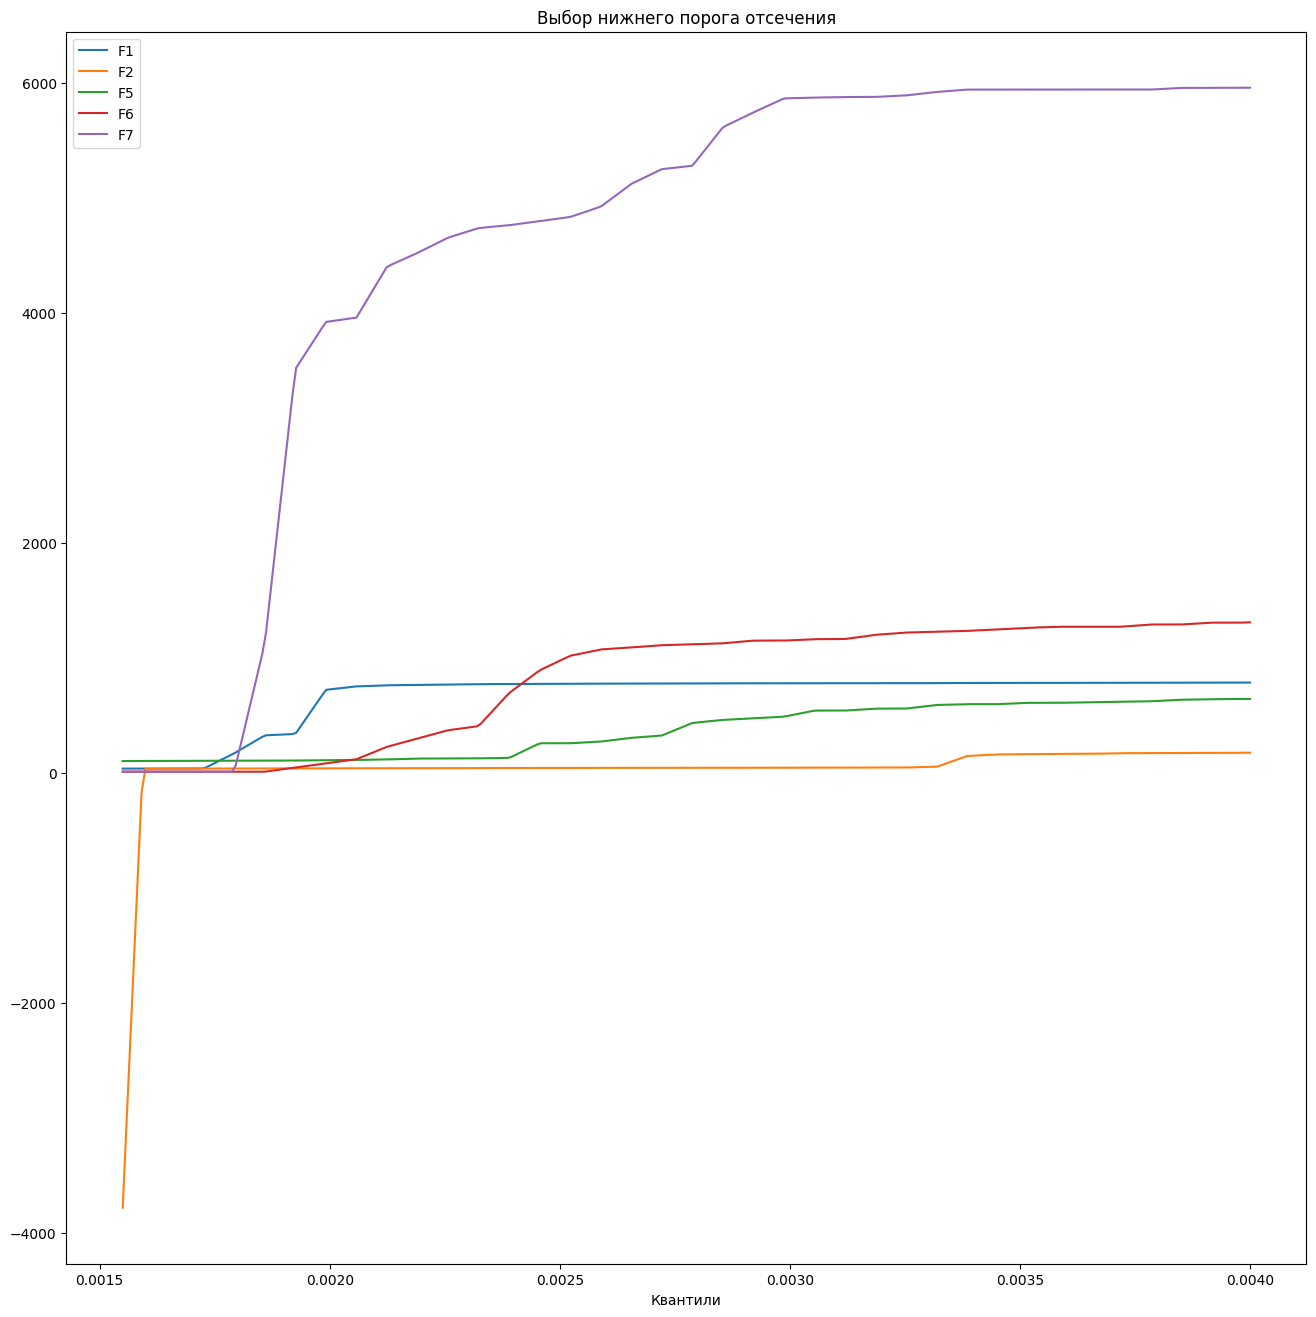

In [26]:
q0 = 0.00155
q1 = 0.0040
pts = 300

plt.figure(figsize=(16,16))
plt.plot(np.linspace(q0, q1, pts), [ df.F1.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F1')
plt.plot(np.linspace(q0, q1, pts), [ df.F2.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F2')
plt.plot(np.linspace(q0, q1, pts), [ df.F5.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F5')
plt.plot(np.linspace(q0, q1, pts), [ df.F6.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F6')
plt.plot(np.linspace(q0, q1, pts), [ df.F7.quantile(q=y) for y in np.linspace(q0, q1, pts) ], label='F7')
plt.title(label='Выбор нижнего порога отсечения')
plt.xlabel('Квантили')
plt.legend()
plt.show()

In [27]:
# Будем отсекать по F7: оставим значения от 3000 до 15000

In [28]:
dfc = df[3000 < df.F7]
dfc = dfc[df.F7 < 15000]

C:\Users\Peter\AppData\Local\Temp\ipykernel_11756\1406491950.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = dfc[df.F7 < 15000]


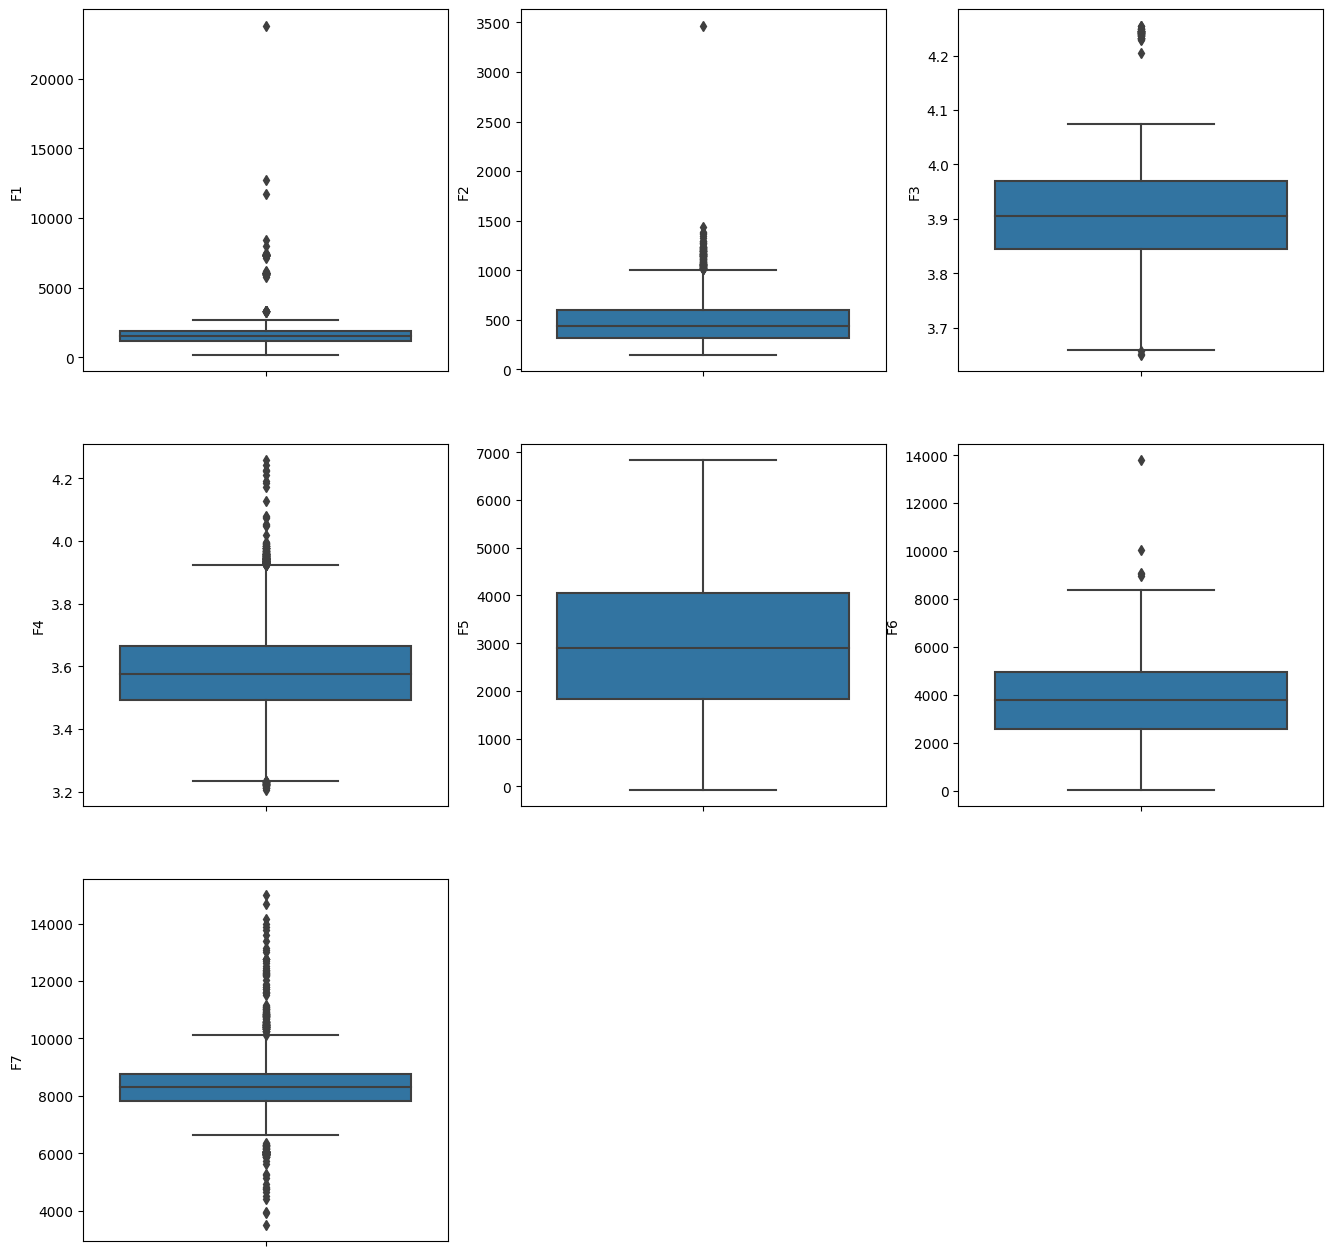

In [29]:
plt.figure(figsize=(16,16))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=col, data=dfc)

plt.show()

In [30]:
# Все еще значительные выбросы у F1 и F2, уберем их

In [31]:
dfc = dfc[df.F1 < 10000]
dfc = dfc[df.F2 < 3000]

C:\Users\Peter\AppData\Local\Temp\ipykernel_11756\2490842494.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = dfc[df.F1 < 10000]
C:\Users\Peter\AppData\Local\Temp\ipykernel_11756\2490842494.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfc = dfc[df.F2 < 3000]


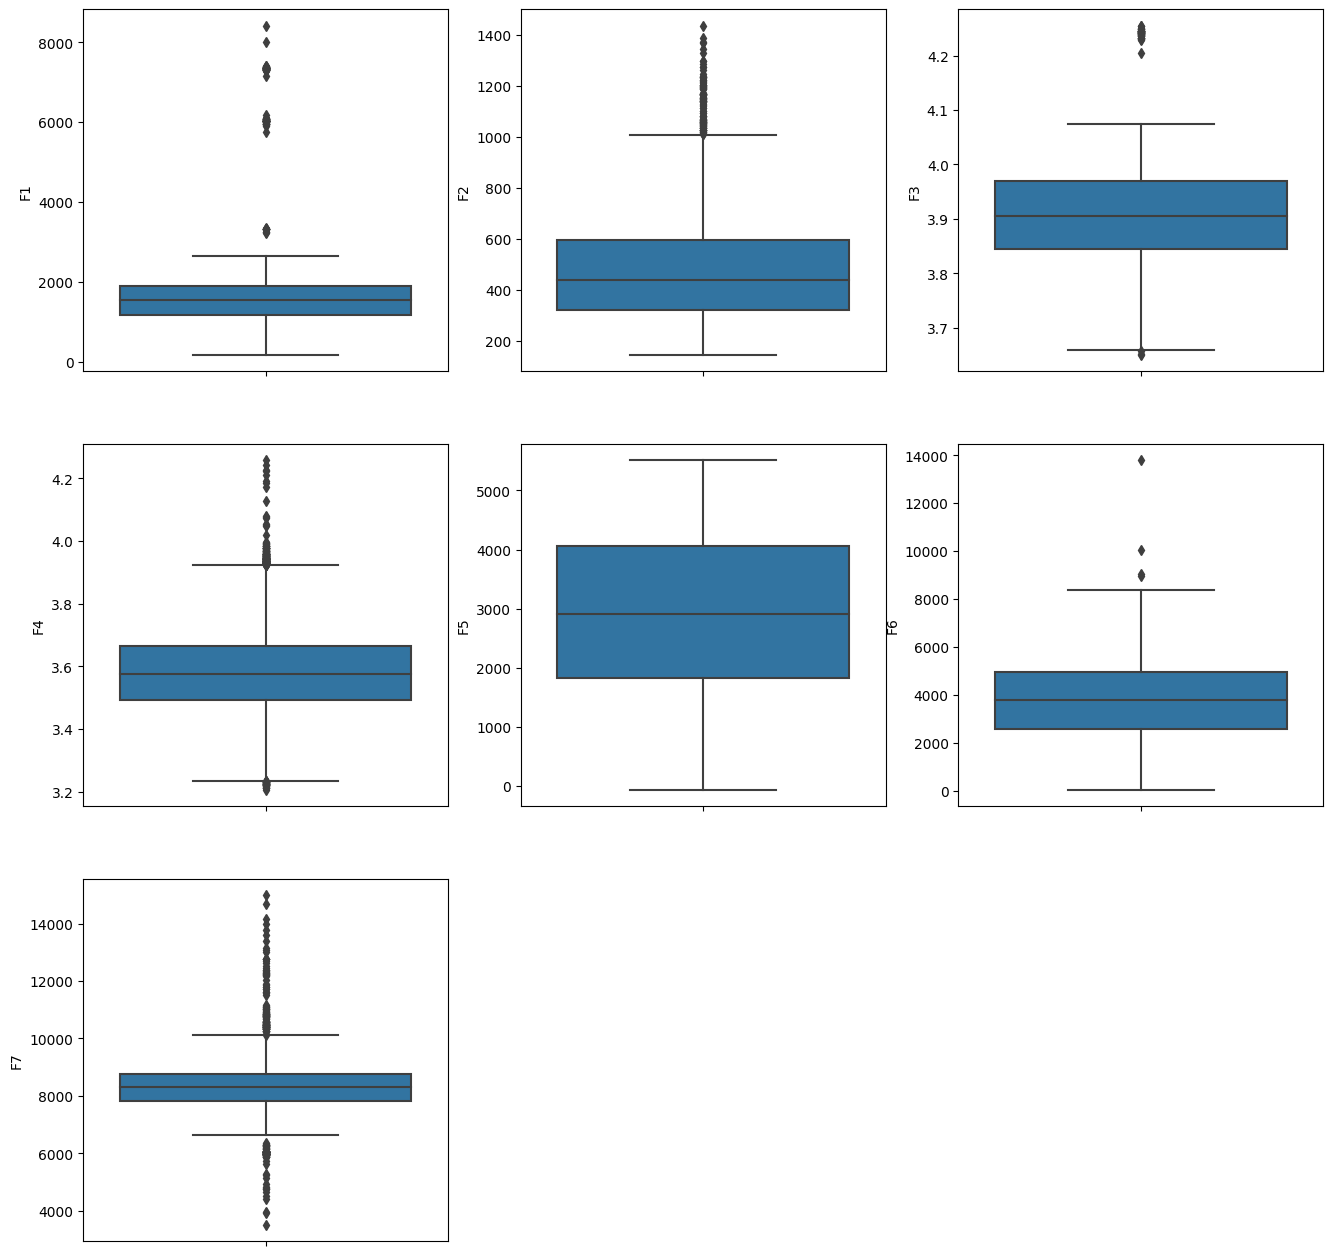

In [32]:
plt.figure(figsize=(16,16))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=col, data=dfc)

plt.show()

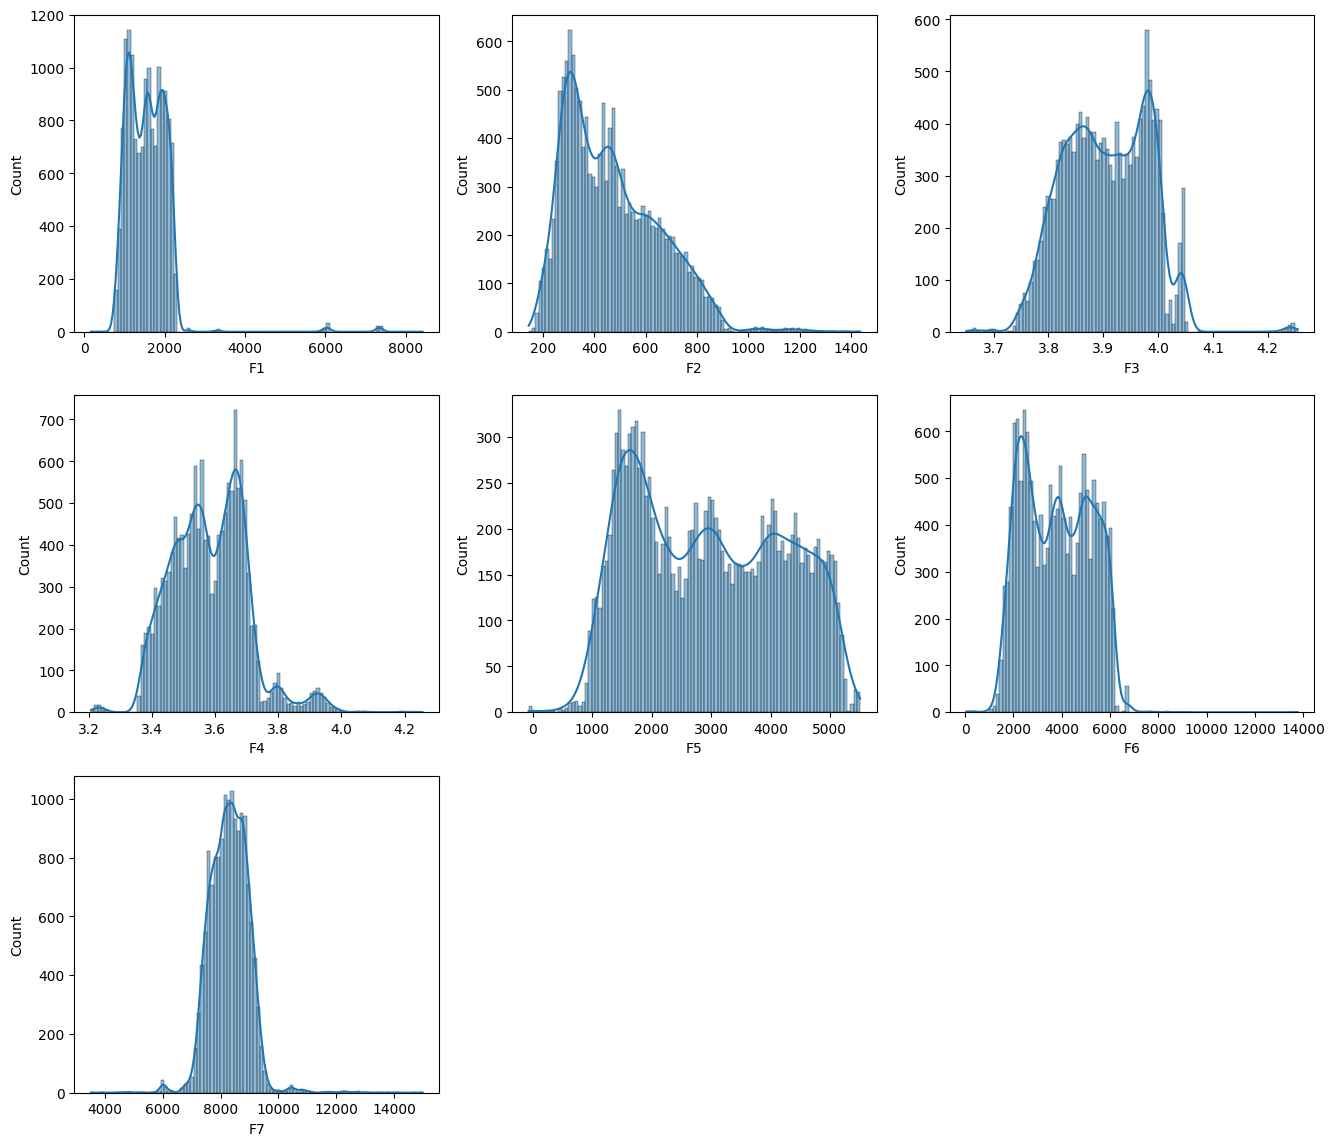

In [33]:
plt.figure(figsize=(16,14))

for i,col in enumerate(new_col_labels):    
    plt.subplot(3, 3, i + 1)
    sns.histplot(x=col, data=dfc, bins=100, kde=True)

plt.show()

In [34]:
print('Отброшено {:.2f}% или {} значений.'.format(100*(1-dfc.shape[0]/df.shape[0]), df.shape[0] - dfc.shape[0]))
print('Осталось {} из {} значений.'.format(dfc.shape[0], df.shape[0]))

Отброшено 1.45% или 219 значений.
Осталось 14845 из 15064 значений.


In [35]:
dfc.reset_index(drop=True, inplace=True)

In [26]:
# dfc.to_csv('data/Battery_RUL_cleaned.csv')

In [27]:
# dfc = pd.read_csv('data/Battery_RUL_cleaned.csv', index_col=0)

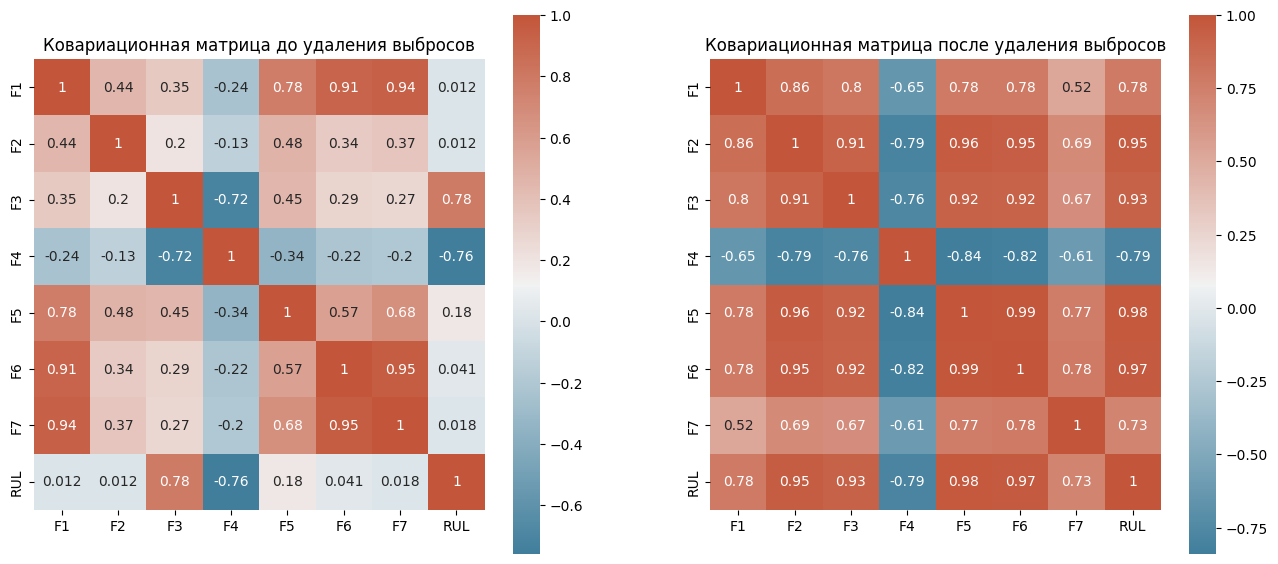

In [36]:
plt.figure(figsize=(16, 7))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.subplot(1, 2, 1)
plt.title('Ковариационная матрица до удаления выбросов')
sns.heatmap(df.corr(), cmap=cmap, annot=True, square=True)
plt.subplot(1, 2, 2)
plt.title('Ковариационная матрица после удаления выбросов')
sns.heatmap(dfc.corr(), cmap=cmap, annot=True, square=True)

plt.show()

In [27]:
# Признаки сильно коррелируют между собой!!!

### Нормализация

In [37]:
MMS_X = MinMaxScaler()
mms_y = MinMaxScaler()

In [38]:
df_X = pd.DataFrame( MMS_X.fit_transform(dfc.iloc[:,:-1]), columns=list(dfc.columns[:-1]) )
df_y = pd.DataFrame( mms_y.fit_transform(dfc[['RUL']]), columns=['RUL'] )

### PCA

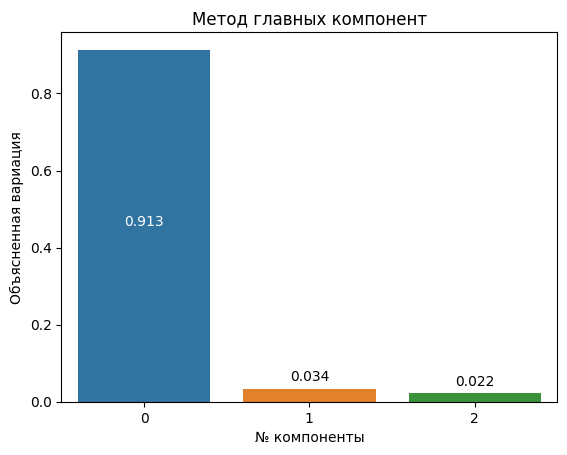

In [39]:
pca = PCA(n_components=3, random_state=0)
pca.fit_transform(df_X)

evr = pca.explained_variance_ratio_
ax=sns.barplot(x=[0,1,2], y=evr)
plt.title('Метод главных компонент')
plt.xlabel('№ компоненты')
plt.ylabel('Объясненная вариация')

ax.text(0, evr[0]/2, round(evr[0],3), color='white', ha='center')
ax.text(1, evr[1] + 0.02, round(evr[1],3), color='black', ha='center')
ax.text(2, evr[2] + 0.02, round(evr[2],3), color='black', ha='center')

plt.show()

In [40]:
# Вывод: данные практически одномерны

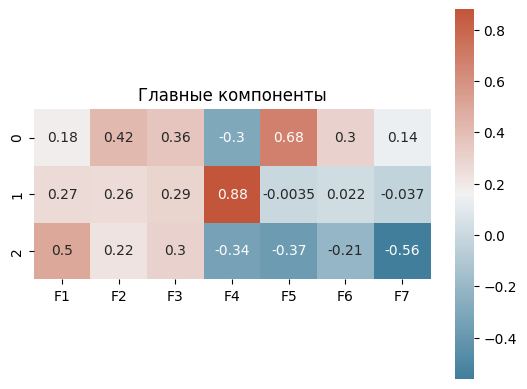

In [41]:
plt.title('Главные компоненты')
sns.heatmap(pd.DataFrame(pca.components_, columns=df_X.columns), cmap=cmap, annot=True, square=True)
plt.show()

### Регрессия - датасет для сбора метрик регрессоров

In [280]:
metrics = pd.DataFrame(
    
    index=[
        'Linear','Ridge','kNN'
        ,'RandomForest'
        ,'Polynomial'
        ,'GradientBoosting'
        #,'Dense NN'
    ], 
    columns=['R2_best','R2_1_feature','R2_2_features','R2_3_features',
             'MAE_best','MAE_1_feature','MAE_2_features', 'MAE_3_features'])

### Регрессия - вспомогательная функция для подбора признаков, кросс-валидации и сохранения метрик

In [321]:
def apply_regressor(reg, X, y):
    
    """
    Для регрессора reg функция проводит подбор признаков и кросс-валидацию 
    на оптимальных наборах, и возвращает список метрик: 
    
    R2 - лучшая во всем тесте
    R2 - лучшая при регрессии на 1 признаке
    R2 - лучшая при регрессии на 2 признаках
    R2 - лучшая при регрессии на 3 признаках
    MAE - лучшая во всем тесте
    MAE - лучшая при регрессии на 1 признаке
    MAE - лучшая при регрессии на 2 признаках
    MAE - лучшая при регрессии на 3 признаках
    
    """
    
    R2_best = 0.0
    R2_1_feature = 0.0
    R2_2_features = 0.0
    R2_3_features = 0.0
    MAE_best = 1e100
    MAE_1_feature = 0.0
    MAE_2_features = 0.0
    MAE_3_features = 0.0
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    print('R2       RMSE    MAE     features')
    print('--------------------------------------')

    n_col = X.shape[1]
    
    for n_f in range(1, n_col + 1):
    
        if n_f == n_col:
            df_Xf = X
        else:    
            sfs = SequentialFeatureSelector(reg, n_features_to_select=n_f)
            df_Xf = sfs.fit_transform(X, y)
    
        cv=cross_validate(reg, df_Xf, y, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'], cv=kf)
    
        if n_f == n_col:
            best_f = '[ALL]'
        else:
            best_f = sfs.get_support(indices=True) + 1
    
        R2 = cv['test_r2'].mean()
        RMSE = -cv['test_neg_root_mean_squared_error'].mean()
        MAE = -cv['test_neg_mean_absolute_error'].mean()
        
        if n_f == 1:
            R2_1_feature = R2
            MAE_1_feature = MAE
        
        if n_f == 2:
            R2_2_features = R2
            MAE_2_features = MAE
            
        if n_f == 3:
            R2_3_features = R2
            MAE_3_features = MAE
            
        if R2 > R2_best: R2_best = R2
        if MAE < MAE_best: MAE_best = MAE
    
        # print(cv['test_r2'].std())
    
        print('{:.4f}   {:.2f}   {:.2f}  '.format(R2, RMSE, MAE), best_f)
        
    return [ R2_best, R2_1_feature, R2_2_features, R2_3_features, MAE_best, MAE_1_feature, MAE_2_features, MAE_3_features ]

### Линейная регрессия

In [282]:
metrics.loc['Linear'] = apply_regressor(LinearRegression(), df_X, dfc.RUL)

R2       RMSE    MAE     features
--------------------------------------
0.9553   67.85   42.86   [5]
0.9595   64.57   41.89   [4 5]
0.9635   61.43   42.71   [3 4 5]
0.9645   60.53   43.53   [3 4 5 7]
0.9649   60.22   43.41   [3 4 5 6 7]
0.9651   60.04   44.10   [2 3 4 5 6 7]
0.9653   59.86   44.75   [ALL]


### Ridge-регрессия (L2-регуляризация)

In [283]:
metrics.loc['Ridge'] = apply_regressor(Ridge(alpha=3.0), df_X, dfc.RUL)

R2       RMSE    MAE     features
--------------------------------------
0.9553   67.87   42.88   [5]
0.9594   64.70   41.69   [4 5]
0.9633   61.54   42.69   [3 4 5]
0.9642   60.79   43.21   [3 4 5 7]
0.9646   60.43   43.05   [3 4 5 6 7]
0.9646   60.48   43.06   [1 3 4 5 6 7]
0.9651   60.10   44.82   [ALL]


### Метод k-ближайших соседей

In [284]:
metrics.loc['kNN'] = apply_regressor(KNeighborsRegressor(n_neighbors=4), df_X, dfc.RUL)

R2       RMSE    MAE     features
--------------------------------------
0.9727   53.11   37.38   [1]
0.9773   48.48   33.10   [1 6]
0.9790   46.62   31.99   [1 5 6]
0.9866   37.21   22.83   [1 4 5 6]
0.9924   27.97   14.31   [1 2 4 5 6]
0.9952   22.31   9.41   [1 2 3 4 5 6]
0.9964   19.30   7.04   [ALL]


### Random Forest

In [126]:
# Внимание! Ячейка работает очень долго!
apply_regressor(RandomForestRegressor(random_state=0), df_X, dfc.RUL)

R2       RMSE    MAE     features
--------------------------------------
0.9696   56.08   38.51   [1]
0.9784   47.26   32.00   [1 6]
0.9813   43.96   29.83   [1 5 6]
0.9880   35.17   22.06   [1 4 5 6]
0.9924   28.04   16.69   [1 2 4 5 6]
0.9956   21.26   11.39   [1 2 3 4 5 6]
0.9966   18.74   9.23   [ALL]


In [302]:
# Внимание! Ячейка работает очень долго!
RFR1 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=250), df_X, dfc.RUL)

R2       RMSE    MAE     features
--------------------------------------
0.9697   56.00   38.46   [1]
0.9784   47.21   31.98   [1 6]
0.9814   43.86   29.76   [1 5 6]
0.9914   29.79   17.95   [1 3 5 6]
0.9941   24.74   14.49   [1 2 3 5 6]
0.9957   21.19   11.34   [1 2 3 4 5 6]
0.9966   18.66   9.19   [ALL]


In [303]:
# Внимание! Ячейка работает очень долго!
RFR2 = apply_regressor(RandomForestRegressor(random_state=0, n_estimators=70), df_X, dfc.RUL)

R2       RMSE    MAE     features
--------------------------------------
0.9696   56.10   38.53   [1]
0.9784   47.26   32.00   [1 6]
0.9813   44.03   29.87   [1 5 6]
0.9879   35.33   22.14   [1 4 5 6]
0.9924   28.12   16.72   [1 2 4 5 6]
0.9956   21.27   11.40   [1 2 3 4 5 6]
0.9966   18.68   9.23   [ALL]


In [304]:
metrics.loc['RandomForest'] = RFR1

### Полиномиальная регрессия

In [288]:
poly = PolynomialFeatures(7, include_bias=False)
dfp = df_X.copy()
dfp = poly.fit_transform(dfp)
dfp = pd.DataFrame(dfp)
dfp.shape

(14845, 3431)

In [289]:
# Проверка корреляции новых признаков

lst = (dfp.corrwith(df_y.iloc[:,0]).abs().sort_values()).reset_index()
of = poly.get_feature_names_out()
for i in lst.index:
    lst.loc[i,'terms'] = of[lst.iloc[i,0]]

lst.tail(15)

,index,0,terms
3416,2,0.928035,F3
3417,110,0.929082,F5^2 F6
3418,112,0.930110,F5 F6^2
3419,33,0.933703,F6 F7
3420,111,0.934943,F5^2 F7
3421,113,0.935262,F5 F6 F7
3422,32,0.946105,F6^2
3423,22,0.949746,F3 F5
3424,23,0.950120,F3 F6
3425,1,0.950237,F2


In [71]:
# Самая лучшая корреляция по-прежнему у F5, новые признаки не смогли его обогнать

In [290]:
# Добавим три самых лучших новых признака

dfpoly = df_X.copy()
dfpoly['F8'] = df_X.F5*df_X.F6
dfpoly['F9'] = df_X.F5**2
dfpoly['F10'] = df_X.F5*df_X.F7

In [291]:
metrics.loc['Polynomial'] = apply_regressor(LinearRegression(), dfpoly, dfc.RUL)

R2       RMSE    MAE     features
--------------------------------------
0.9553   67.85   42.86   [5]
0.9595   64.57   41.89   [4 5]
0.9635   61.43   42.71   [3 4 5]
0.9641   60.86   42.84   [ 3  4  5 10]
0.9647   60.42   43.95   [ 2  3  4  5 10]
0.9653   59.85   43.72   [ 2  3  4  5  9 10]
0.9654   59.80   43.66   [ 2  3  4  5  6  9 10]
0.9658   59.42   44.43   [ 1  2  3  4  5  6  9 10]
0.9658   59.43   44.41   [ 1  2  3  4  5  6  8  9 10]
0.9667   58.64   44.28   [ALL]


In [53]:
# Вывод: нелинейность не настолько сильная

### Градиентный бустинг

In [61]:
# Оценим оптимальныое значение learning_rate на полном наборе признаков

for i in range(1,100):
    cv=cross_validate(GradientBoostingRegressor(learning_rate=0.03 + i/100), 
               df_X, dfc.RUL, scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'], 
               cv=KFold(n_splits=5, shuffle=True, random_state=0))
    print('{}  {:.4f}   {:.2f}   {:.2f}  '.format(i,
            cv['test_r2'].mean(), 
            -cv['test_neg_root_mean_squared_error'].mean(),
            -cv['test_neg_mean_absolute_error'].mean()))

1  0.9818   43.37   32.59  
2  0.9827   42.31   31.43  
3  0.9833   41.61   30.80  
4  0.9835   41.32   30.49  
5  0.9840   40.72   30.03  
6  0.9846   39.96   29.45  
7  0.9849   39.47   29.01  
8  0.9854   38.87   28.57  
9  0.9856   38.52   28.27  
10  0.9862   37.74   27.69  
11  0.9863   37.57   27.60  
12  0.9868   36.88   27.10  
13  0.9869   36.81   26.98  
14  0.9872   36.44   26.57  
15  0.9872   36.37   26.50  
16  0.9873   36.25   26.33  
17  0.9875   35.93   26.15  
18  0.9880   35.25   25.70  
19  0.9881   35.05   25.51  
20  0.9882   34.90   25.41  
21  0.9884   34.59   25.17  
22  0.9886   34.30   24.84  
23  0.9887   34.18   24.73  
24  0.9886   34.28   24.87  
25  0.9888   33.98   24.63  
26  0.9889   33.81   24.43  
27  0.9891   33.58   24.31  
28  0.9889   33.82   24.29  
29  0.9892   33.39   24.05  
30  0.9893   33.22   24.04  
31  0.9894   33.15   23.90  
32  0.9893   33.29   23.76  
33  0.9895   32.99   23.63  
34  0.9894   33.04   23.52  
35  0.9895   32.89   23

In [ ]:
# Лучшая итерация №61 соответствует learning_rate = 0.64

In [297]:
metrics.loc['GradientBoosting'] = apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate=0.64), df_X, dfc.RUL)

R2       RMSE    MAE     features
--------------------------------------
0.9758   50.04   35.33   [1]
0.9788   46.86   33.76   [1 6]
0.9790   46.56   33.53   [1 5 6]
0.9814   43.87   31.31   [1 4 5 6]
0.9874   36.11   25.96   [1 3 4 5 6]
0.9888   34.10   24.36   [1 2 3 4 5 6]
0.9908   30.91   21.45   [ALL]


In [63]:
for i in range(1,6):
    print(i)
    apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate=0.64 - i*0.03), df_X, dfc.RUL)

1
R2       RMSE    MAE     features
--------------------------------------
0.9760   49.76   35.25   [1]
0.9790   46.64   33.63   [1 6]
0.9791   46.48   33.60   [1 5 6]
0.9814   43.83   31.36   [1 4 5 6]
0.9875   36.01   26.00   [1 3 4 5 6]
0.9885   34.43   24.56   [1 2 3 4 5 6]
0.9905   31.40   21.87   [ALL]
2
R2       RMSE    MAE     features
--------------------------------------
0.9762   49.64   35.19   [1]
0.9790   46.57   33.70   [1 6]
0.9792   46.40   33.51   [1 5 6]
0.9811   44.24   31.76   [1 4 5 6]
0.9873   36.22   26.15   [1 3 4 5 6]
0.9885   34.50   24.68   [1 2 3 4 5 6]
0.9906   31.11   21.75   [ALL]
3
R2       RMSE    MAE     features
--------------------------------------
0.9764   49.38   35.15   [1]
0.9793   46.30   33.62   [1 6]
0.9793   46.25   33.60   [1 5 6]
0.9815   43.73   31.48   [1 4 5 6]
0.9874   36.15   26.09   [1 3 4 5 6]
0.9885   34.50   24.89   [1 2 3 4 5 6]
0.9904   31.51   22.09   [ALL]
4
R2       RMSE    MAE     features
----------------------------------

In [64]:
for i in range(1,11):
    print(i)
    apply_regressor(GradientBoostingRegressor(random_state=0, learning_rate=0.64 + i*0.03), df_X, dfc.RUL)

1
R2       RMSE    MAE     features
--------------------------------------
0.9757   50.11   35.27   [1]
0.9790   46.60   33.58   [1 6]
0.9787   46.90   33.68   [1 5 6]
0.9812   44.14   31.38   [1 4 5 6]
0.9876   35.80   25.74   [1 3 4 5 6]
0.9886   34.26   24.37   [1 2 3 4 5 6]
0.9906   31.26   21.72   [ALL]
2
R2       RMSE    MAE     features
--------------------------------------
0.9753   50.53   35.49   [1]
0.9783   47.33   33.99   [1 6]
0.9785   47.11   33.72   [1 5 6]
0.9810   44.39   31.22   [1 4 5 6]
0.9874   36.05   25.61   [1 3 4 5 6]
0.9889   33.89   23.92   [1 2 3 4 5 6]
0.9905   31.35   21.77   [ALL]
3
R2       RMSE    MAE     features
--------------------------------------
0.9752   50.61   35.49   [1]
0.9781   47.62   33.78   [1 6]
0.9783   47.31   33.65   [1 5 6]
0.9807   44.65   31.36   [1 4 5 6]
0.9874   36.13   25.59   [1 3 4 5 6]
0.9885   34.42   24.19   [1 2 3 4 5 6]
0.9905   31.27   21.48   [ALL]
4
R2       RMSE    MAE     features
----------------------------------

### Полносвязная нейронная сеть

In [233]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()
    plt.grid(True)

In [258]:
model = Sequential()
model.add(Dense(35, input_dim=7, activation='relu'))
model.add(Dense(35, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')

In [259]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, shuffle=True, random_state=0)

In [260]:
hist=model.fit(df_X_train, df_y_train, epochs=50, validation_split=0.2, batch_size=1000, verbose=0)

In [261]:
y_pred = model.predict(df_X_test)

116/116 [==============================] - 0s 733us/step


In [262]:
print(r2_score(df_y_test, y_pred),
    mean_absolute_error(mms_y.inverse_transform(df_y_test), mms_y.inverse_transform(y_pred)),
     mean_squared_error(mms_y.inverse_transform(df_y_test), mms_y.inverse_transform(y_pred))**0.5)

0.974201895761117 40.43520333817036 51.39944860881775


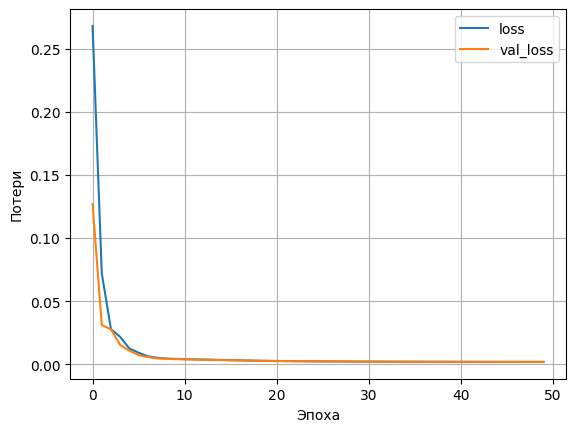

In [263]:
plot_loss(hist)

### Сравнение регрессоров

In [421]:
metrics

,R2_best,R2_1_feature,R2_2_features,R2_3_features,MAE_best,MAE_1_feature,MAE_2_features,MAE_3_features
Linear,0.965325,0.955305,0.959547,0.963458,41.890696,42.862455,41.890696,42.709987
Ridge,0.965053,0.955281,0.959377,0.963327,41.688289,42.879856,41.688289,42.694885
kNN,0.996387,0.972703,0.977271,0.978987,7.044358,37.379774,33.104547,31.988329
RandomForest,0.996630,0.969674,0.978445,0.981394,9.188349,38.460748,31.981739,29.764894
Polynomial,0.966741,0.955305,0.959547,0.963458,41.890696,42.862455,41.890696,42.709987
GradientBoosting,0.990760,0.975769,0.978764,0.979038,21.446427,35.329622,33.763127,33.528016


In [314]:
# metrics.to_csv('data/regressor_metrics.csv')

In [317]:
# metrics = pd.read_csv('data/regressor_metrics.csv', index_col=0)

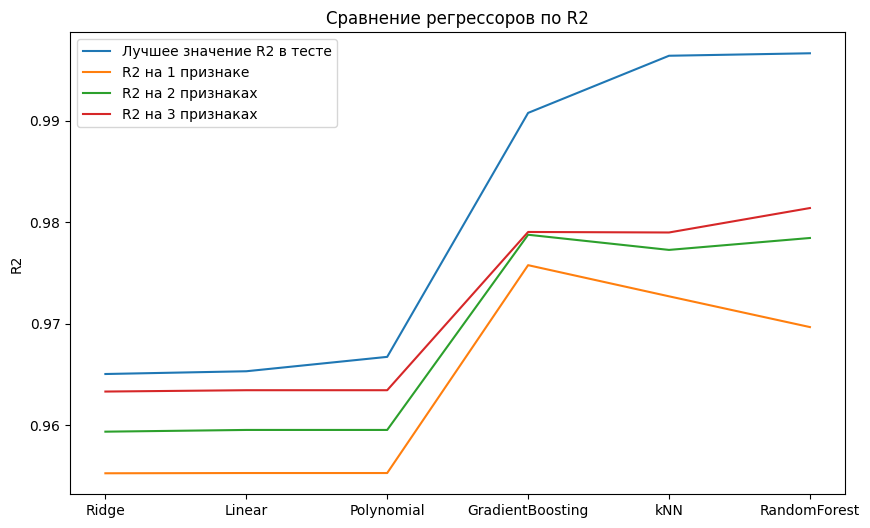

In [310]:
# R2

metrics_sorted = metrics.sort_values('R2_best')

plt.figure(figsize=(10,6))
plt.plot(metrics_sorted.index, metrics_sorted.R2_best, label='Лучшее значение R2 в тесте')
plt.plot(metrics_sorted.index, metrics_sorted.R2_1_feature, label='R2 на 1 признаке')
plt.plot(metrics_sorted.index, metrics_sorted.R2_2_features, label='R2 на 2 признаках')
plt.plot(metrics_sorted.index, metrics_sorted.R2_3_features, label='R2 на 3 признаках')
plt.ylabel('R2')
plt.title('Сравнение регрессоров по R2')
plt.legend()
plt.show()

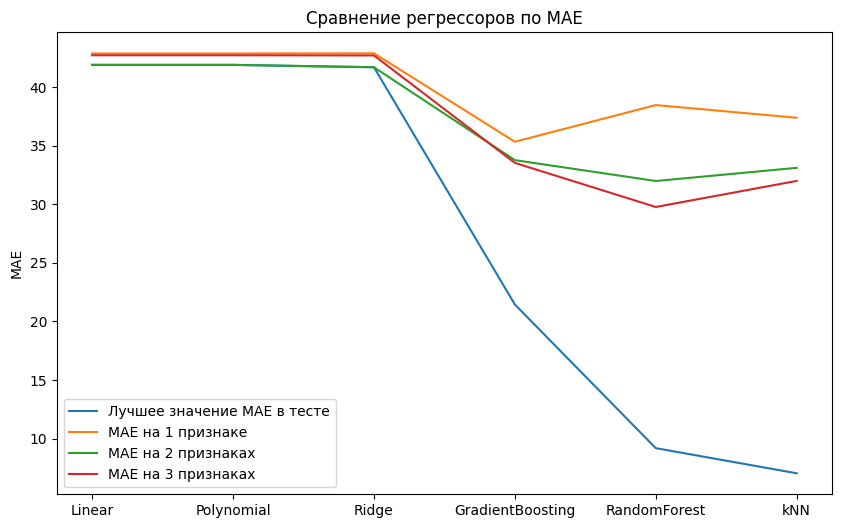

In [311]:
# MAE

metrics_sorted = metrics.sort_values('MAE_best', ascending=False)

plt.figure(figsize=(10,6))
plt.plot(metrics_sorted.index, metrics_sorted.MAE_best, label='Лучшее значение MAE в тесте')
plt.plot(metrics_sorted.index, metrics_sorted.MAE_1_feature, label='MAE на 1 признаке')
plt.plot(metrics_sorted.index, metrics_sorted.MAE_2_features, label='MAE на 2 признаках')
plt.plot(metrics_sorted.index, metrics_sorted.MAE_3_features, label='MAE на 3 признаках')
plt.ylabel('MAE')
plt.title('Сравнение регрессоров по MAE')
plt.legend()
plt.show()

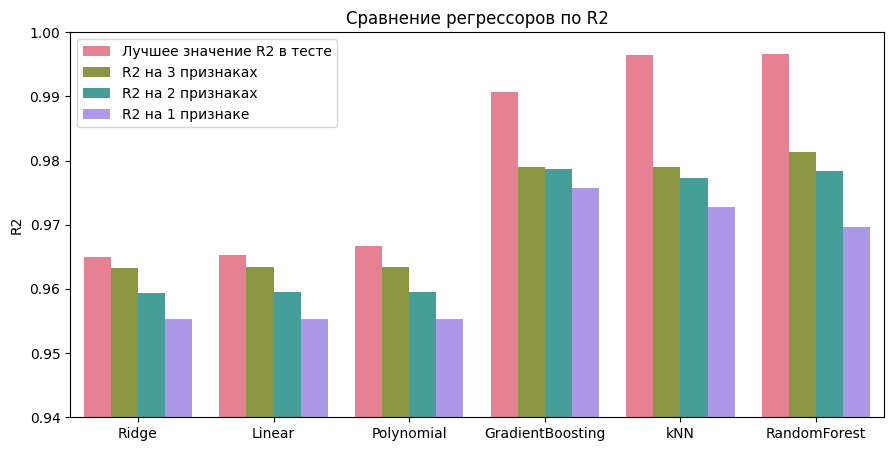

In [419]:
# R2

metrics_sorted = metrics.sort_values('R2_best')

metrics_melted = pd.melt(
    metrics_sorted.reset_index()[['index','R2_best','R2_3_features','R2_2_features','R2_1_feature']],
    id_vars='index')

bar_labels_r2 = {
        'R2_best' : 'Лучшее значение R2 в тесте',
        'R2_1_feature' : 'R2 на 1 признаке',
        'R2_2_features' : 'R2 на 2 признаках',
        'R2_3_features' : 'R2 на 3 признаках'
    }
    
metrics_melted.variable = metrics_melted.variable.apply(lambda x: bar_labels_r2[x])

plt.figure(figsize=(10.5, 5))
sns.barplot(data=metrics_melted, x='index', y='value', hue='variable', palette='husl')
plt.legend(loc='upper left')
plt.xlabel('')
plt.ylabel('R2')
plt.title('Сравнение регрессоров по R2')
plt.ylim(0.94, 1)
plt.show()

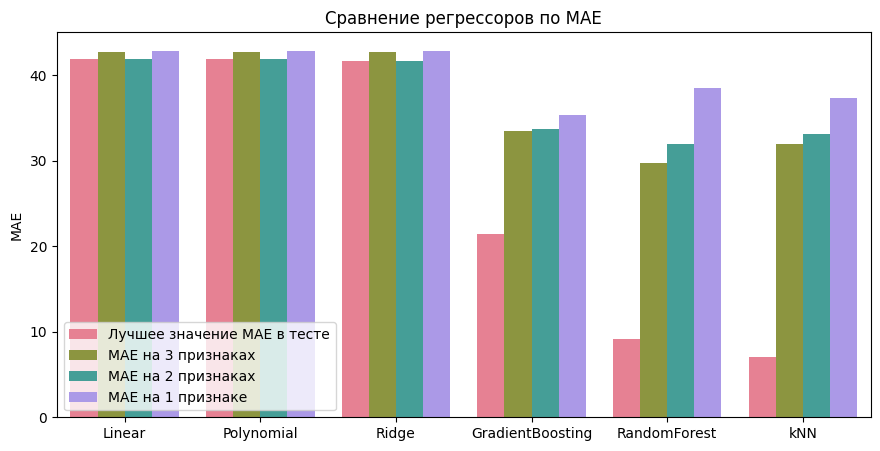

In [420]:
# MAE

metrics_sorted = metrics.sort_values('MAE_best', ascending=False)

metrics_melted = pd.melt(
    metrics_sorted.reset_index()[['index','MAE_best','MAE_3_features','MAE_2_features','MAE_1_feature']],
    id_vars='index')

bar_labels_mae = {
        'MAE_best' : 'Лучшее значение MAE в тесте',
        'MAE_1_feature' : 'MAE на 1 признаке',
        'MAE_2_features' : 'MAE на 2 признаках',
        'MAE_3_features' : 'MAE на 3 признаках'
    }
    
metrics_melted.variable = metrics_melted.variable.apply(lambda x: bar_labels_mae[x])

plt.figure(figsize=(10.5, 5))
sns.barplot(data=metrics_melted, x='index', y='value', hue='variable', palette='husl')
plt.legend(loc='lower left')
plt.xlabel('')
plt.ylabel('MAE')
plt.title('Сравнение регрессоров по MAE')
plt.show()